## 1. 데이터 준비와 확인

In [1]:
# gensim 3.4.0 설치. 초기 1회만 가동.
#pip install gensim==3.4.0

In [2]:
# 라이브러리 로드
import pandas as pd         # 데이터 구분
from konlpy.tag import Mecab   # 토크나이저
import numpy as np            # 텐서 형식 지원
from collections import Counter   # 단어의 개수 세기

import tensorflow as tf        # 길이 맞춘 후 빈칸 패드로 채우기, 훈련 시키기, 시험하기.
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt # 그래프 그리기
import os
from tensorflow.keras.initializers import Constant  # 워드 벡터 임베딩
from gensim.models import Word2Vec

from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore', category = UserWarning, module = 'bs4')

# 데이터 로드 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
# 모델 훈련 파라미터 설정. 편의상 위로 올림.
# 공통 파라미터 설정

word_vector_dim = 200    # 워드 벡터의 차원 지정. 200이 아니면 워드 임베딩 차원 안맞아 에러 발생.
epochs = 10 
batch_size = 1024
es = EarlyStopping(monitor = 'val_loss', patience = 2, verbose = 1)  # 조기 종료 감시

# LSTM 파라미터
LSTM_layer = 128  # LSTM state 벡터의 차원수 기본값은 8. (변경 가능)
LSTM_epochs = epochs
LSTM_batch_size = batch_size

# CNN1D 파라미터
CNN1D_MaxPoolingValue = 6
CNN1D_epochs = epochs
CNN1D_batch_size = batch_size

# onlyGMP 파라미터
onlyGMP_epochs = epochs
onlyGMP_batch_size = batch_size

## 2. 데이터로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전(word_to_index) 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
tokenizer = Mecab()  ### 윈도우에서 실행하려면 추가 작업 필요.
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10000   # 단어 개수
def load_data(train_data, test_data, num_words):
    
    # 중복, 결측치 제거
    # drop_duplicates(): 중복값 처리(1개만 남기고 나머지는 제거. 어느쪽을 남길지는 keep = 'first', 'last', False로 선택.)
    # documnet: 대사.
    # inplace: rename, drop 등의 메뉴를 사용할 때, 변경값을 저장(True)한다.
    # subset: 검색 대상 열
    train_data.drop_duplicates(subset=['document'], inplace=True)  
    train_data = train_data.dropna(how = 'any') # 결측값 처리. any: 행 또는 열에 NaN이 1개만 있어도 드롭.(디폴트값.)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # 한국어 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:  # 문장에는 트레인 데이터의 대사를 입력
        temp_X = tokenizer.morphs(sentence) # 토큰화. morphs: 형태소 추출
        # 만약 stopwords에 해당하는 word가 없다면, temp_X 안의 word 들을 temp_X에 넣는다.
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:  # 문자에 트레인 데이터 입력
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist() #tolist: 같은 레벨에 있는 데이터끼리 묶어준다.
    counter = Counter(words)  # 단어의 개수 세기
    counter = counter.most_common(num_words-4)  ### 데이터의 개수가 많은 순으로 정렬된 배열을 리턴. 숫자가 입력되면 그 숫자만큼만 리턴.9996개인가??
    print("counter의 항목 10개 시범출력:")
    print(counter[:10]) #리스트 타입.
    print("counter의 길이는:", len(counter))
    vocab = ['', '', '', ''] + [key for key, _ in counter] 
    print("vocab의 항목 10개 시범출력")
    print(vocab[:10])  #리스트 타입
    word_to_index = {word:index for index, word in enumerate(vocab)} 
    #print(word_to_index.items()) #딕셔너리 타입. 일부만 출력하려면 for 문을 써줘야 한다.
    
    # 사전(word_to_index) 구성
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환    
    X_train = list(map(wordlist_to_indexlist, X_train))
    type(X_train)
    X_test = list(map(wordlist_to_indexlist, X_test))
    type(X_test)
    
    # X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index


X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words)

counter의 항목 10개 시범출력:
[('.', 159415), ('영화', 57338), ('다', 54971), ('고', 47196), ('하', 44376), ('을', 29832), ('보', 25603), ('..', 22655), ('게', 22161), (',', 22047)]
counter의 길이는: 9996
vocab의 항목 10개 시범출력
['', '', '', '', '.', '영화', '다', '고', '하', '을']


In [5]:
print('X_train 타입 확인')
print(type(X_train))
print('X_train 항목 3개 시범 출력')
print(X_train[:3]) # 이중 리스트.
print('X_test 타입 확인')
print(type(X_test))
print('X_test 항목 3개 시범 출력')
print(X_test[:3]) # 이중 리스트

X_train 타입 확인
<class 'list'>
X_train 항목 3개 시범 출력
[[32, 74, 919, 4, 4, 39, 228, 20, 33, 748], [1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391], [24, 205, 3]]
X_test 타입 확인
<class 'list'>
X_test 항목 3개 시범 출력
[[832, 130], [3], [85, 111, 58, 4, 70, 950, 332, 44, 38, 100, 37, 641, 3557, 73, 917]]


In [6]:
print('y_train 타입 확인')
print(type(y_train))
print('y_train 항목 10개 시범 출력')
print(y_train[:10]) # 이중 리스트.
print('y_test 타입 확인')
print(type(y_test))
print('t_test 항목 10개 시범 출력')
print(y_test[:10]) # 이중 리스트

y_train 타입 확인
<class 'numpy.ndarray'>
y_train 항목 10개 시범 출력
[0 1 0 0 1 0 0 0 1 1]
y_test 타입 확인
<class 'numpy.ndarray'>
t_test 항목 10개 시범 출력
[1 0 0 0 0 1 0 0 0 1]


In [7]:
print('word_to_index 딕셔너리의 초반 항목 확인.')
for k, v in word_to_index.items():
    print("key:", k,", value :", v)
    if v>10:
        break
print('**0, 1, 2번 항이 빈 것을 확인함.**')

word_to_index 딕셔너리의 초반 항목 확인.
key:  , value : 3
key: . , value : 4
key: 영화 , value : 5
key: 다 , value : 6
key: 고 , value : 7
key: 하 , value : 8
key: 을 , value : 9
key: 보 , value : 10
key: .. , value : 11
**0, 1, 2번 항이 빈 것을 확인함.**


In [8]:
print('특수 항목 삽입을 위한 위치 조정.')
#word_to_index = {k:(v+1) for k,v in word_to_index.items()}
word_to_index = {k:v for k,v in word_to_index.items()}
print('특수 항목 삽입 및 초반 항목 재확인.')
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
#word_to_index["<UNUSED>"] = 3
for k, v in word_to_index.items():
    print("key:", k,", value :", v)
    if v>10:
        break
print('**초반 항목 변경사항 확인.**')

특수 항목 삽입을 위한 위치 조정.
특수 항목 삽입 및 초반 항목 재확인.
key:  , value : 3
key: . , value : 4
key: 영화 , value : 5
key: 다 , value : 6
key: 고 , value : 7
key: 하 , value : 8
key: 을 , value : 9
key: 보 , value : 10
key: .. , value : 11
**초반 항목 변경사항 확인.**


### 중간회고: 위 딕셔너리에서 0~3번은 왜 출력이 안 되는가?
- 항목을 일일이 출력해 확인해 본 결과 잘 되었음.
- 특수항목이 제대로 나오지 않는 이유는 잘 모르겠음.
- 다른 인원들과 토론해 보았으나 만족스런 결과는 나오지 않음.

In [9]:
print(word_to_index["<PAD>"])
print(word_to_index["<BOS>"])
print(word_to_index["<UNK>"])
#print(word_to_index["<UNUSED>"])
print(word_to_index[""])
print(word_to_index["."])
print(word_to_index["영화"])

0
1
2
3
4
5


In [10]:
index_to_word = {index:word for word, index in word_to_index.items()}
print("word to index 항목 추출")
for k, v in word_to_index.items():
    print("key:", k,", value :", v)
    if v>10:
        break

word to index 항목 추출
key:  , value : 3
key: . , value : 4
key: 영화 , value : 5
key: 다 , value : 6
key: 고 , value : 7
key: 하 , value : 8
key: 을 , value : 9
key: 보 , value : 10
key: .. , value : 11


In [11]:
print(index_to_word[0])
print(index_to_word[1])
print(index_to_word[2])
print(index_to_word[3])
print(index_to_word[4])
print(index_to_word[5])
print(index_to_word[6])

<PAD>
<BOS>
<UNK>

.
영화
다


In [12]:
# 문장 <-> 단어 인덱스 리스트 벡터로 변환해 주는 함수들 
# 단, 모든 문장은 <BOS>로 시작하고 없는 것은 '<UNK>'로 처리.

# 한 개의 문장을 단어 인덱스 리스트 벡터로 인코딩
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]\
+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]
    #return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장들을 한꺼번에 단어 인덱스 리스트 벡터들로 인코딩
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 한 개의 단어 인덱스 리스트 벡터를 문장으로 디코딩
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 단어 인덱스 리스트 벡터들을 한꺼번에 문장들로 디코딩
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가

In [13]:
total_data_text = list(X_train) + list(X_test)

# 텍스트 데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차를 계산해 본다.
print(f'감상평 문장의 평균 길이는 {round(np.mean(num_tokens),2)}자이다.')
print(f'모든 감상평에서 가장 긴 문장의 길이는 {np.max(num_tokens)}자이다.')
print(f'감상평 문장 길이의 표준편차는 {round(np.std(num_tokens),2)}이다.')

print('사용할 문장의 최대 길이를 (평균 + 3 x 표준편차)로 다듬으면')
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)
print(f'다듬은 최대 문장 길이는 {maxlen}자이다.')
print(f'이 때 전체 문장의 {round(np.sum(num_tokens < max_tokens) / len(num_tokens)*100, 2)}%가 다듬은 최대 문장 길이를 넘지 않는다. ')


감상평 문장의 평균 길이는 15.97자이다.
모든 감상평에서 가장 긴 문장의 길이는 116자이다.
감상평 문장 길이의 표준편차는 12.84이다.
사용할 문장의 최대 길이를 (평균 + 3 x 표준편차)로 다듬으면
다듬은 최대 문장 길이는 54자이다.
이 때 전체 문장의 97.21%가 다듬은 최대 문장 길이를 넘지 않는다. 


#### 사용할 문장의 최대 길이를 (평균 + 2 x 표준편차)로 다듬으면
#### 다듬은 최대 문장 길이는 41자이다.
#### 이 때 전체 문장의 93.42%가 다듬은 최대 문장 길이를 넘지 않는다.

### 두 경우를 비교하여, 신뢰성을 좀더 확보하고자 포함되는 문장의 비율이 95%를 넘게 하고 싶었다.
### 이에 따라 최대길이를 (평균 + 3 x 표준편차)로 조정하였다.


In [14]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)
print('문장 길이 통일 및 빈칸 <PAD> 채우기 완료')

문장 길이 통일 및 빈칸 <PAD> 채우기 완료


In [15]:
print(f"훈련데이터의 형태는 {X_train.shape}이다.")
print(f"시험데이터의 형태는 {X_test.shape}이다.")

훈련데이터의 형태는 (146182, 54)이다.
시험데이터의 형태는 (49157, 54)이다.


# 4. 모델 구성 및 validation set 구성

- 3종류 이상 다양하게 구성.

# 5. 모델 훈련 개시
# 6. Loss, Accuracy 그래프 시각화


## (1) 필수 파라미터 설정

In [16]:
# 공통 파라미터 설정. 나머지는 편의상 맨 위로 올림.
vocab_size = len(word_to_index)   

## (2) LSTM model
#### RNN을 이용. RNN은 시간축의 신규 입력에 따라 변하는 현재상태를 묘사하는 state machine으로 설계됨. Memory property.

In [17]:
# 모델 설계
LSTM_model = tf.keras.Sequential()
LSTM_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_model.add(tf.keras.layers.LSTM(LSTM_layer))    
LSTM_model.add(tf.keras.layers.Dense(8, activation='relu'))
LSTM_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim .
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               168448    
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 모델 훈련
LSTM_model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

LSTM_history = LSTM_model.fit(X_train, y_train,
                    epochs = LSTM_epochs,
                    batch_size = LSTM_batch_size,
                    validation_data = (X_test, y_test), callbacks = [es], verbose = 1)

# 모델 평가
LSTM_results = LSTM_model.evaluate(X_test, y_test, verbose = 2)
print('LSTM 모델의 손실값 및 정확도는:')
print(LSTM_results)

Epoch 1/10
143/143 [==============================] - 8s 36ms/step - loss: 0.5972 - accuracy: 0.6570 - val_loss: 0.4096 - val_accuracy: 0.8226
Epoch 2/10
143/143 [==============================] - 5s 33ms/step - loss: 0.3616 - accuracy: 0.8444 - val_loss: 0.3573 - val_accuracy: 0.8449
Epoch 3/10
143/143 [==============================] - 5s 33ms/step - loss: 0.3247 - accuracy: 0.8614 - val_loss: 0.3494 - val_accuracy: 0.8479
Epoch 4/10
143/143 [==============================] - 5s 34ms/step - loss: 0.3025 - accuracy: 0.8709 - val_loss: 0.3463 - val_accuracy: 0.8493
Epoch 5/10
143/143 [==============================] - 5s 34ms/step - loss: 0.2787 - accuracy: 0.8807 - val_loss: 0.3480 - val_accuracy: 0.8537
Epoch 6/10
143/143 [==============================] - 5s 34ms/step - loss: 0.2580 - accuracy: 0.8911 - val_loss: 0.3668 - val_accuracy: 0.8527
Epoch 00006: early stopping
1537/1537 - 3s - loss: 0.3668 - accuracy: 0.8527
LSTM 모델의 손실값 및 정확도는:
[0.36680319905281067, 0.8526557683944702]


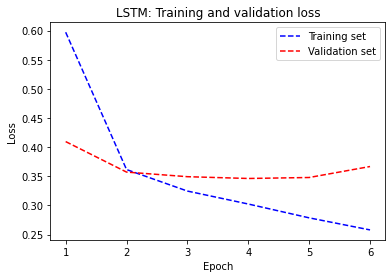

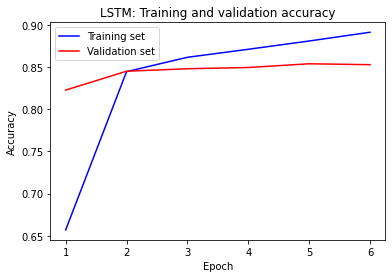

In [19]:
# 훈련에 따른 손실 변화 시각화
LSTM_history_dict = LSTM_history.history
acc = LSTM_history_dict['accuracy']
val_acc = LSTM_history_dict['val_accuracy']
loss = LSTM_history_dict['loss']
val_loss = LSTM_history_dict['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b--', label = 'Training set')
plt.plot(epochs, val_loss, 'r--', label = 'Validation set')
plt.title('LSTM: Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 훈련에 따른 정확도 변화 시각화
plt.clf()
plt.plot(epochs, acc, 'b', label = 'Training set')
plt.plot(epochs, val_acc, 'r', label = 'Validation set')
plt.title('LSTM: Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## (3) 1D CNN model
- 문장 전체를 한 방향으로 길이 7짜리 필터로 스캐닝하면서 7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류.
- 병렬처리를 하기 때문에 RNN 보다 학습속도도 훨씬 빠르게 진행된다.

In [20]:
# 모델 설계
CNN1D_model = tf.keras.Sequential()
CNN1D_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, 
                                 input_length=maxlen, trainable=True))   # trainable을 True로 주면 Fine-tuning
CNN1D_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN1D_model.add(tf.keras.layers.MaxPooling1D(CNN1D_MaxPoolingValue))
CNN1D_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN1D_model.add(tf.keras.layers.GlobalMaxPooling1D())
CNN1D_model.add(tf.keras.layers.Dense(8, activation='relu'))
CNN1D_model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 
CNN1D_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 54, 200)           2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 48, 16)            22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [21]:
# 모델 훈련
#from tensorflow.keras.initializers import Constant
CNN1D_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
CNN1D_history = CNN1D_model.fit(X_train, y_train,
                    epochs = CNN1D_epochs,
                    batch_size = CNN1D_batch_size,
                    validation_data = (X_test, y_test), callbacks = [es], verbose=1)

# 모델 평가
CNN1D_results = CNN1D_model.evaluate(X_test, y_test, verbose=2)
print('CNN1D 모델의 손실값 및 정확도는:')
print(CNN1D_results)

Epoch 1/10
143/143 [==============================] - 3s 13ms/step - loss: 0.4769 - accuracy: 0.7742 - val_loss: 0.3503 - val_accuracy: 0.8502
Epoch 2/10
143/143 [==============================] - 2s 11ms/step - loss: 0.3136 - accuracy: 0.8667 - val_loss: 0.3361 - val_accuracy: 0.8563
Epoch 3/10
143/143 [==============================] - 2s 11ms/step - loss: 0.2743 - accuracy: 0.8876 - val_loss: 0.3334 - val_accuracy: 0.8584
Epoch 4/10
143/143 [==============================] - 2s 11ms/step - loss: 0.2366 - accuracy: 0.9067 - val_loss: 0.3423 - val_accuracy: 0.8575
Epoch 5/10
143/143 [==============================] - 2s 11ms/step - loss: 0.1956 - accuracy: 0.9270 - val_loss: 0.3666 - val_accuracy: 0.8534
Epoch 00005: early stopping
1537/1537 - 3s - loss: 0.3666 - accuracy: 0.8534
CNN1D 모델의 손실값 및 정확도는:
[0.3666130602359772, 0.8534491658210754]


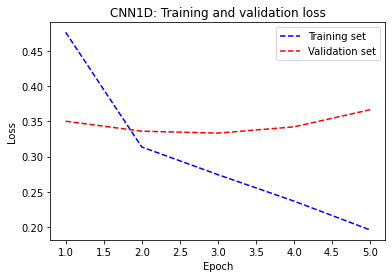

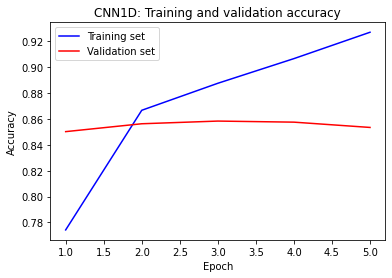

In [22]:
# 훈련에 따른 손실 변화 시각화
CNN1D_history_dict = CNN1D_history.history
acc = CNN1D_history_dict['accuracy']
val_acc = CNN1D_history_dict['val_accuracy']
loss = CNN1D_history_dict['loss']
val_loss = CNN1D_history_dict['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b--', label = 'Training set')
plt.plot(epochs, val_loss, 'r--', label = 'Validation set')
plt.title('CNN1D: Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 훈련에 따른 정확도 변화 시각화
plt.clf()
plt.plot(epochs, acc, 'b', label = 'Training set')
plt.plot(epochs, val_acc, 'r', label = 'Validation set')
plt.title('CNN1D: Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## (4) only MaxPooling model
- 전체 문장 중에서 단 하나의 가장 중요한 단어만 특징으로 추출하여 그것으로 문장의 긍/부정을 평가함.

In [23]:
# 모델 설계
onlyGMP_model = tf.keras.Sequential()
onlyGMP_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, 
                                            input_shape=(None,)))
onlyGMP_model.add(tf.keras.layers.GlobalMaxPooling1D())
onlyGMP_model.add(tf.keras.layers.Dense(8, activation = 'relu'))
onlyGMP_model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))  # 최종 출력은 긍/부정 ldim
onlyGMP_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 모델 훈련
onlyGMP_model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

onlyGMP_history = onlyGMP_model.fit(X_train, y_train,
                    epochs = onlyGMP_epochs,
                    batch_size = onlyGMP_batch_size,
                    validation_data = (X_test, y_test), callbacks = [es], verbose = 1)

# 모델 평가
onlyGMP_results = onlyGMP_model.evaluate(X_test, y_test, verbose = 2)
print('onlyGMP 모델의 손실값 및 정확도는:')
print(onlyGMP_results)

Epoch 1/10
143/143 [==============================] - 2s 8ms/step - loss: 0.5222 - accuracy: 0.7978 - val_loss: 0.3707 - val_accuracy: 0.8418
Epoch 2/10
143/143 [==============================] - 1s 7ms/step - loss: 0.3291 - accuracy: 0.8606 - val_loss: 0.3424 - val_accuracy: 0.8515
Epoch 3/10
143/143 [==============================] - 1s 6ms/step - loss: 0.2854 - accuracy: 0.8815 - val_loss: 0.3406 - val_accuracy: 0.8536
Epoch 4/10
143/143 [==============================] - 1s 7ms/step - loss: 0.2539 - accuracy: 0.8976 - val_loss: 0.3449 - val_accuracy: 0.8536
Epoch 5/10
143/143 [==============================] - 1s 7ms/step - loss: 0.2246 - accuracy: 0.9124 - val_loss: 0.3550 - val_accuracy: 0.8530
Epoch 00005: early stopping
1537/1537 - 2s - loss: 0.3550 - accuracy: 0.8530
onlyGMP 모델의 손실값 및 정확도는:
[0.3549930453300476, 0.8530219793319702]


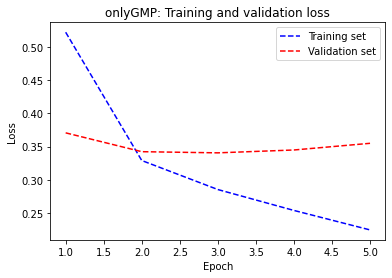

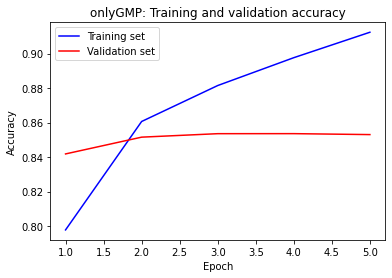

In [25]:
# 훈련에 따른 손실 변화 시각화
onlyGMP_history_dict = onlyGMP_history.history
acc = onlyGMP_history_dict['accuracy']
val_acc = onlyGMP_history_dict['val_accuracy']
loss = onlyGMP_history_dict['loss']
val_loss = onlyGMP_history_dict['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b--', label = 'Training set')
plt.plot(epochs, val_loss, 'r--', label = 'Validation set')
plt.title('onlyGMP: Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 훈련에 따른 정확도 변화 시각화
plt.clf()
plt.plot(epochs, acc, 'b', label = 'Training set')
plt.plot(epochs, val_acc, 'r', label = 'Validation set')
plt.title('onlyGMP: Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 7. 학습된 Embedding layer 분석

In [26]:
# 워드벡터 로드
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word_vector_kr/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

In [27]:
# 유사어 확인
test_words = ['사랑','눈물','이별','노래','추격']  # 있을 것으로 생각되는 단어 임의 선정.
              
for i in range(len(test_words)):
    print(f'{i+1}번째 단어 "{test_words[i]}"에 대한 유사어는 아래와 같습니다')
    print(word2vec.similar_by_word(test_words[i]))
    print('\n')

1번째 단어 "사랑"에 대한 유사어는 아래와 같습니다
[('슬픔', 0.7216662764549255), ('행복', 0.6759077310562134), ('절망', 0.6468985080718994), ('기쁨', 0.6458414196968079), ('이별', 0.6334798336029053), ('추억', 0.6320937275886536), ('인생', 0.6216273307800293), ('애정', 0.6206069588661194), ('연인', 0.6186063289642334), ('유혹', 0.5965287685394287)]


2번째 단어 "눈물"에 대한 유사어는 아래와 같습니다
[('땀', 0.6310575008392334), ('슬픔', 0.5787195563316345), ('이별', 0.5772002935409546), ('추억', 0.5725258588790894), ('한숨', 0.5546674728393555), ('슬프', 0.5339798927307129), ('웃음', 0.5284000039100647), ('울부짖', 0.5240477323532104), ('울음', 0.5148942470550537), ('온몸', 0.5059491395950317)]


3번째 단어 "이별"에 대한 유사어는 아래와 같습니다
[('헤어지', 0.6900225877761841), ('슬픔', 0.6873862147331238), ('추억', 0.6457439661026001), ('슬프', 0.6412862539291382), ('재회', 0.6345380544662476), ('사랑', 0.6334798336029053), ('첫사랑', 0.6128619909286499), ('고독', 0.6117805242538452), ('절망', 0.5997450947761536), ('작별', 0.5857374668121338)]


4번째 단어 "노래"에 대한 유사어는 아래와 같습니다
[('가사', 0.7066930532455444), 

/tmp/ipykernel_2957/584593154.py:6: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  print(word2vec.similar_by_word(test_words[i]))


In [28]:
# embedding_matrix에 확인한 워드 벡터 임베딩
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_2957/3648516215.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_2957/3648516215.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


# 8. 한국어 Word2Vec 임베딩 활용한 성능개선

## (1) 워드벡터 임베딩된 LSTM 모델

In [29]:
# 모델 설계
WV_LSTM_model = tf.keras.Sequential()
WV_LSTM_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim,
                                         embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용. 워드벡터 반영포인트.
                                         input_shape=(None,)))
WV_LSTM_model.add(tf.keras.layers.LSTM(LSTM_layer))    
WV_LSTM_model.add(tf.keras.layers.Dense(8, activation='relu'))
WV_LSTM_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim .

WV_LSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [30]:
# 모델 훈련
WV_LSTM_model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

WV_LSTM_history = WV_LSTM_model.fit(X_train, y_train,
                    epochs = LSTM_epochs,
                    batch_size = LSTM_batch_size,
                    validation_data = (X_test, y_test), callbacks = [es], verbose = 1)

# 모델 평가
WV_LSTM_results = WV_LSTM_model.evaluate(X_test, y_test, verbose = 2)
print('WV_LSTM 모델의 손실값 및 정확도는:')
print(WV_LSTM_results)

Epoch 1/10
143/143 [==============================] - 6s 36ms/step - loss: 0.6929 - accuracy: 0.5051 - val_loss: 0.6957 - val_accuracy: 0.5155
Epoch 2/10
143/143 [==============================] - 5s 35ms/step - loss: 0.5109 - accuracy: 0.7318 - val_loss: 0.3940 - val_accuracy: 0.8212
Epoch 3/10
143/143 [==============================] - 5s 34ms/step - loss: 0.3375 - accuracy: 0.8546 - val_loss: 0.3344 - val_accuracy: 0.8549
Epoch 4/10
143/143 [==============================] - 5s 35ms/step - loss: 0.2926 - accuracy: 0.8768 - val_loss: 0.3259 - val_accuracy: 0.8590
Epoch 5/10
143/143 [==============================] - 5s 34ms/step - loss: 0.2644 - accuracy: 0.8904 - val_loss: 0.3221 - val_accuracy: 0.8608
Epoch 6/10
143/143 [==============================] - 5s 34ms/step - loss: 0.2420 - accuracy: 0.9013 - val_loss: 0.3167 - val_accuracy: 0.8634
Epoch 7/10
143/143 [==============================] - 5s 34ms/step - loss: 0.2220 - accuracy: 0.9113 - val_loss: 0.3291 - val_accuracy: 0.8634

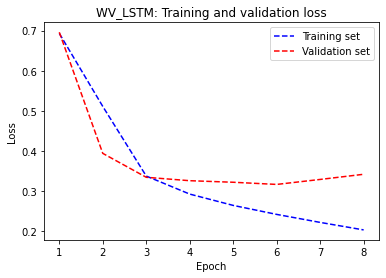

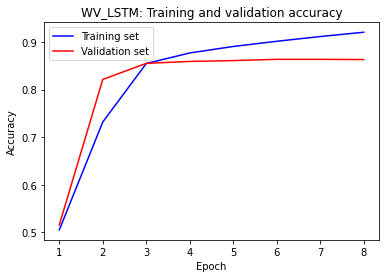

In [31]:
# 훈련에 따른 손실 변화 시각화
WV_LSTM_history_dict = WV_LSTM_history.history
acc = WV_LSTM_history_dict['accuracy']
val_acc = WV_LSTM_history_dict['val_accuracy']
loss = WV_LSTM_history_dict['loss']
val_loss = WV_LSTM_history_dict['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b--', label = 'Training set')
plt.plot(epochs, val_loss, 'r--', label = 'Validation set')
plt.title('WV_LSTM: Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 훈련에 따른 정확도 변화 시각화
plt.clf()
plt.plot(epochs, acc, 'b', label = 'Training set')
plt.plot(epochs, val_acc, 'r', label = 'Validation set')
plt.title('WV_LSTM: Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## (2) 워드벡터 임베딩된 1D CNN 모델

In [32]:
# 모델 설계
WV_CNN1D_model = tf.keras.Sequential()
WV_CNN1D_model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용. 워드벡터 반영포인트.
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
WV_CNN1D_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
WV_CNN1D_model.add(tf.keras.layers.MaxPooling1D(CNN1D_MaxPoolingValue))
WV_CNN1D_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
WV_CNN1D_model.add(tf.keras.layers.GlobalMaxPooling1D())
WV_CNN1D_model.add(tf.keras.layers.Dense(8, activation='relu'))
WV_CNN1D_model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 
WV_CNN1D_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 54, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [33]:
# 모델 훈련
WV_CNN1D_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
WV_CNN1D_history = WV_CNN1D_model.fit(X_train, y_train,
                    epochs = CNN1D_epochs,
                    batch_size = CNN1D_batch_size,
                    validation_data = (X_test, y_test), callbacks = [es], verbose=1)

# 모델 평가
WV_CNN1D_results = WV_CNN1D_model.evaluate(X_test, y_test, verbose=2)
print('WV_CNN1D 모델의 손실값 및 정확도는:')
print(WV_CNN1D_results)

Epoch 1/10
143/143 [==============================] - 2s 12ms/step - loss: 0.5728 - accuracy: 0.6900 - val_loss: 0.4750 - val_accuracy: 0.7786
Epoch 2/10
143/143 [==============================] - 2s 11ms/step - loss: 0.4173 - accuracy: 0.8121 - val_loss: 0.3959 - val_accuracy: 0.8241
Epoch 3/10
143/143 [==============================] - 2s 11ms/step - loss: 0.3508 - accuracy: 0.8489 - val_loss: 0.3691 - val_accuracy: 0.8376
Epoch 4/10
143/143 [==============================] - 2s 11ms/step - loss: 0.3137 - accuracy: 0.8674 - val_loss: 0.3554 - val_accuracy: 0.8457
Epoch 5/10
143/143 [==============================] - 2s 11ms/step - loss: 0.2879 - accuracy: 0.8797 - val_loss: 0.3532 - val_accuracy: 0.8480
Epoch 6/10
143/143 [==============================] - 2s 11ms/step - loss: 0.2681 - accuracy: 0.8910 - val_loss: 0.3569 - val_accuracy: 0.8480
Epoch 7/10
143/143 [==============================] - 2s 11ms/step - loss: 0.2506 - accuracy: 0.8990 - val_loss: 0.3591 - val_accuracy: 0.8486

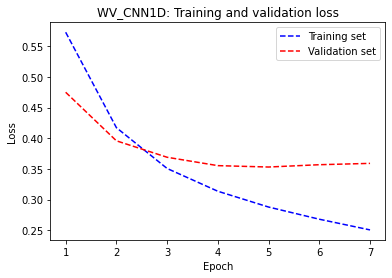

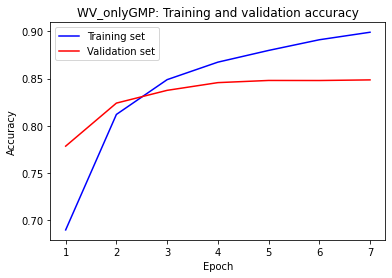

In [34]:
# 훈련에 따른 손실 변화 시각화
WV_CNN1D_history_dict = WV_CNN1D_history.history
acc = WV_CNN1D_history_dict['accuracy']
val_acc = WV_CNN1D_history_dict['val_accuracy']
loss = WV_CNN1D_history_dict['loss']
val_loss = WV_CNN1D_history_dict['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b--', label = 'Training set')
plt.plot(epochs, val_loss, 'r--', label = 'Validation set')
plt.title('WV_CNN1D: Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 훈련에 따른 정확도 변화 시각화
plt.clf()
plt.plot(epochs, acc, 'b', label = 'Training set')
plt.plot(epochs, val_acc, 'r', label = 'Validation set')
plt.title('WV_onlyGMP: Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## (3) 워드벡터 임베딩된 only MaxPooling 모델

In [35]:
# 모델 설계
WV_onlyGMP_model = tf.keras.Sequential()
WV_onlyGMP_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim,
                                               embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용. 워드벡터 반영포인트.
                                            input_shape=(None,)))
WV_onlyGMP_model.add(tf.keras.layers.GlobalMaxPooling1D())
WV_onlyGMP_model.add(tf.keras.layers.Dense(8, activation = 'relu'))
WV_onlyGMP_model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))  # 최종 출력은 긍/부정 ldim
WV_onlyGMP_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [36]:
# 모델 훈련
WV_onlyGMP_model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

WV_onlyGMP_history = WV_onlyGMP_model.fit(X_train, y_train,
                    epochs = onlyGMP_epochs,
                    batch_size = onlyGMP_batch_size,
                    validation_data = (X_test, y_test), callbacks = [es], verbose = 1)

# 모델 평가
WV_onlyGMP_results = WV_onlyGMP_model.evaluate(X_test, y_test, verbose = 2)
print('WV_onlyGMP 모델의 손실값 및 정확도는:')
print(WV_onlyGMP_results)

Epoch 1/10
143/143 [==============================] - 1s 8ms/step - loss: 0.7154 - accuracy: 0.5087 - val_loss: 0.6870 - val_accuracy: 0.5612
Epoch 2/10
143/143 [==============================] - 1s 6ms/step - loss: 0.6757 - accuracy: 0.5905 - val_loss: 0.6593 - val_accuracy: 0.6313
Epoch 3/10
143/143 [==============================] - 1s 7ms/step - loss: 0.6091 - accuracy: 0.6762 - val_loss: 0.5573 - val_accuracy: 0.7211
Epoch 4/10
143/143 [==============================] - 1s 7ms/step - loss: 0.5210 - accuracy: 0.7471 - val_loss: 0.5050 - val_accuracy: 0.7576
Epoch 5/10
143/143 [==============================] - 1s 6ms/step - loss: 0.4730 - accuracy: 0.7773 - val_loss: 0.4717 - val_accuracy: 0.7765
Epoch 6/10
143/143 [==============================] - 1s 6ms/step - loss: 0.4393 - accuracy: 0.7971 - val_loss: 0.4524 - val_accuracy: 0.7887
Epoch 7/10
143/143 [==============================] - 1s 6ms/step - loss: 0.4145 - accuracy: 0.8116 - val_loss: 0.4354 - val_accuracy: 0.7975
Epoch 

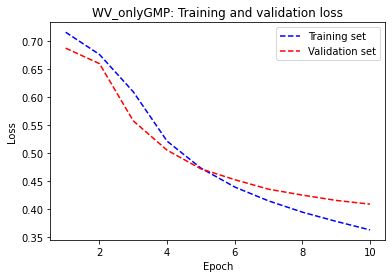

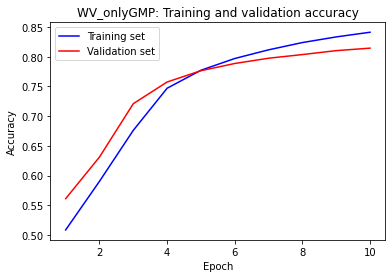

In [37]:
# 훈련에 따른 손실 변화 시각화
WV_onlyGMP_history_dict = WV_onlyGMP_history.history

acc = WV_onlyGMP_history_dict['accuracy']
val_acc = WV_onlyGMP_history_dict['val_accuracy']
loss = WV_onlyGMP_history_dict['loss']
val_loss = WV_onlyGMP_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b--', label = 'Training set')
plt.plot(epochs, val_loss, 'r--', label = 'Validation set')
plt.title('WV_onlyGMP: Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 훈련에 따른 정확도 변화 시각화
plt.clf()

plt.plot(epochs, acc, 'b', label = 'Training set')
plt.plot(epochs, val_acc, 'r', label = 'Validation set')
plt.title('WV_onlyGMP: Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 9. 결과 정리 및 회고

In [38]:
# 주요 파라미터 정리
HyperParameter = [['Vocab size', num_words],['WV dim.',word_vector_dim],['Epochs', epochs[-1]], ['Batch_size', batch_size], ['Layer', LSTM_layer],['MaxPooling',CNN1D_MaxPoolingValue]]

df_HP = pd.DataFrame(HyperParameter, index = ['Common','Common','Common','Common', 'LSTM', 'CNN1D'], columns =['Name','Value'])
df_HP.to_csv("HyperParameter.csv", mode='a', header=False)
print('  < 주요 파라미터 설정 >')
df_HP



  < 주요 파라미터 설정 >


,Name,Value
Common,Vocab size,10000
Common,WV dim.,200
Common,Epochs,10
Common,Batch_size,1024
LSTM,Layer,128
CNN1D,MaxPooling,6


In [39]:
# 최종 결과 정리
TotalResult = pd.DataFrame(index=['Loss', 'Val. Acc.'])

TotalResult['LSTM']= LSTM_results
TotalResult['CNN1D']= CNN1D_results
TotalResult['onlyGMP']= onlyGMP_results
TotalResult['WV_LSTM']= WV_LSTM_results
TotalResult['WV_CNN1D']= WV_CNN1D_results
TotalResult['WV_onlyGMP']= WV_onlyGMP_results
TotalResult.iloc[0] = TotalResult.iloc[0].round(2) 
TotalResult.iloc[1]= TotalResult.iloc[1].apply('{:.2%}'.format)
TotalResult = TotalResult.transpose()
TotalResult.to_csv("TotalResult.csv", mode='a', header=False)
print('       < 최종 결과 >')
TotalResult

       < 최종 결과 >


,Loss,Val. Acc.
LSTM,0.37,85.27%
CNN1D,0.37,85.34%
onlyGMP,0.35,85.30%
WV_LSTM,0.34,86.29%
WV_CNN1D,0.36,84.86%
WV_onlyGMP,0.41,81.45%


## 결과 정리

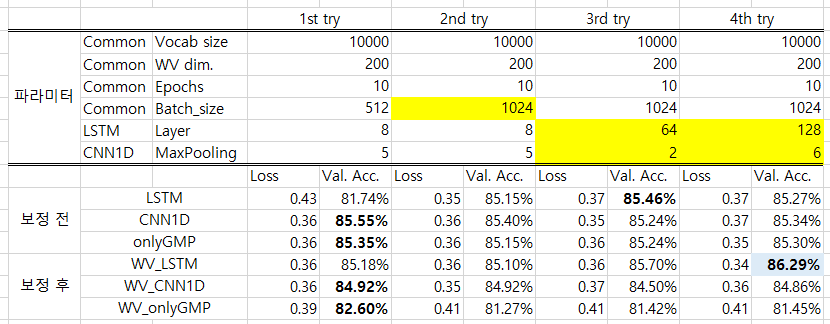
- Epoch는 대부분 2~3차 시도에서 최고 값을 내고 정체 혹은 하향을 겪었다.
- Batch size는 대부분 큰 영향을 주지 않았다. 늘렸을 때 오히려 소폭 감소하였다.
- LSTM layer는 크면 클수록 더 좋은 결과를 보였다. Batch size가 작을 때는 워드 벡터 임베딩의 효과가 두드러졌고 Batch size가 클 때는 상승폭이 낮아졌다.
- CNN1D의 MaxPooling은 유의미한 결과를 보이지 않았다. 10 이상 큰 수에서는 negative dimension이라는 에러가 출력되었다.

## 회고

- 소요시간을 표에 삽입하여 CNN1D 모델과 다른 모델들과의 비교를 한눈에 하고 싶었는데 못했다. 다음 번엔 소요시간도 출력하는 방법을 찾아보자.
- 활성함수, 옵티마이저도 손댈 여유가 없었다. 나중엔 이들도 Fine-tune을 해봐야겠다.
- 그림도 subplot을 사용해서 합칠 수 있을 것 같다. 다음 번엔 합쳐서 가독성을 높이는 방법도 찾아봐야 겠다.
- 단어장 100000개 하니 CNN1D에서 리소스 에러 발생. 다시 10000으로 낮춤.
- 금일 조기종료 구문을 배워 삽입하였다. 검증 결과가 시도를 거듭할수록 악화되는 케이스가 있었다. 지난 번 가사 만들기 때도 양상이 유사했던 것으로 기억하는데, 왜 시도가 거듭되어도 큰 개선이 없는지에 대한 고민이 많이 필요하다.
- 워드 임베딩으로 유사단어 출력 결과가 이상하여 보정하느라 고생을 많이 했다. 최종적으로 내린 결론은, 서버에 올린 ko.bin 파일이 정상적으로 업로드되지 않거나, 되더라도 안정적으로 유지되지 않는다는 것. 
- 파일을 정상업로드 한 줄 알고 있다가 다른 사람들의 조언으로 ko.bin 파일 상태를 다시 한 번 확인해보니 2M. 정상버전은 50M 였기에 삭제하고 재업로드 후 확인해보니 양호하게 작동되었다. 